In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import tensorflow as tf
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from environment.models.simple_control_fixed import SimpleControlledFixedEnv

2024-07-11 10:45:44.871688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 10:45:44.936242: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Specify the `render_mode` parameter to show the attempts of the agent in a pop up window.
env = SimpleControlledFixedEnv()
env.max_t = 2
env.delta_t = 0.01
env.fixed_error_ctrl_pump = [0, 0, 0, 0]
env.fixed_error_ctrl_alice = [np.pi, np.pi, 0, 0]
env.fixed_error_ctrl_bob = [0, 0, 0, 0]
env.fixed_errors_flags = [True, True, True, True, 
                          False, False, True, True, 
                          True, True, True, True]
env.latency = 1 # ! remove latency to test

# ENV SPECIFIC
num_actions = 2
num_states = 2

upper_bound = np.pi
lower_bound = -np.pi

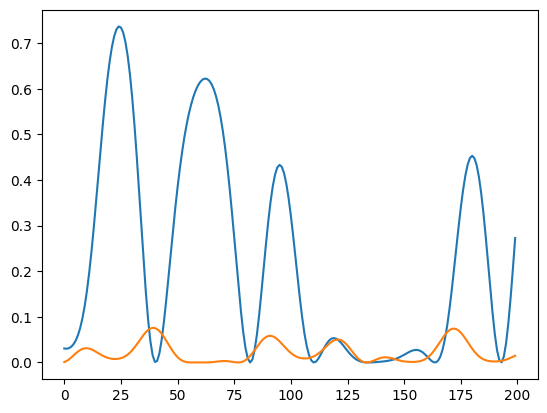

In [3]:
state = env.reset()
done = False
while not done:
    state, reward, done = env.step()
    if done:
        break

plt.plot(env.qber_history)

In [4]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [5]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') observation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self,
        state_batch,
        action_batch,
        reward_batch,
        next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            # print([next_state_batch, target_actions])
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.reduce_mean(tf.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype="float32")
        next_state_batch = tf.convert_to_tensor(
            self.next_state_buffer[batch_indices]
        )

        # print(f"state: {state_batch}")
        # print(f"action: {action_batch}")
        
        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(target, original, tau):
    target_weights = target.get_weights()
    original_weights = original.get_weights()

    for i in range(len(target_weights)):
        target_weights[i] = original_weights[i] * tau + target_weights[i] * (1 - tau)

    target.set_weights(target_weights)

In [6]:
from keras.regularizers import l2

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(512, activation="relu")(inputs)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(512, activation="relu")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(256, activation="relu", kernel_regularizer=l2(0.01))(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)

    outputs = outputs * upper_bound
    model = keras.Model(inputs, outputs)
    return model

def get_critic():
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(64, activation="relu")(state_input)
    state_out = layers.BatchNormalization()(state_out)
    state_out = layers.LeakyReLU()(state_out)
    state_out = layers.Dense(128, activation="relu")(state_out)
    state_out = layers.BatchNormalization()(state_out)
    state_out = layers.LeakyReLU()(state_out)

    action_input = layers.Input(shape=(num_actions,))
    action_out = layers.Dense(128, activation="relu")(action_input)
    action_out = layers.BatchNormalization()(action_out)
    action_out = layers.LeakyReLU()(action_out)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(512, activation="relu", kernel_regularizer=l2(0.01))(concat)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(256, activation="relu", kernel_regularizer=l2(0.01))(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = keras.Model([state_input, action_input], outputs)

    return model

In [7]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return np.squeeze(legal_action)

In [8]:
std_dev = 0.4
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.01
actor_lr = 0.001

critic_optimizer = keras.optimizers.Adam(critic_lr)
actor_optimizer = keras.optimizers.Adam(actor_lr)

total_episodes = 200
# Discount factor for future rewards
gamma = 0.8
# Used to update target networks
tau = 0.002

buffer = Buffer(50000, 64)

2024-07-11 10:45:46.560377: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Initialize tqdm loop
pbar = tqdm(range(total_episodes))

for ep in pbar:
    prev_state, _ = env.reset()
    episodic_reward = 0

    while True:
        tf_prev_state = tf.expand_dims(
            tf.convert_to_tensor(prev_state), 0
        )

        action = policy(tf_prev_state, ou_noise)
        _action = [action[0], action[1], 0 ,0]
        # print(f"action: {action}")
        # Receive state and reward from environment.
        state, reward, done = env.step(np.zeros(4), _action, np.zeros(4))#, action[4:8], action[8:12])

        # print(f"state: {state}")
        # print(f"reward: {reward}")
        # print(f"action: {action}")
        # print(f"prev_state: {prev_state}")
        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()

        update_target(target_actor, actor_model, tau)
        update_target(target_critic, critic_model, tau)

        # End this episode when `done` or `truncated` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    # print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)
    
    # Update tqdm description with average reward
    pbar.set_description(f"Episode {ep} Avg Reward: {avg_reward:.2f} Last Steps: {env.max_t/env.delta_t}")

Episode 199 Avg Reward: 309.67 Last Steps: 200.0: 100%|██████████| 200/200 [06:31<00:00,  1.96s/it]


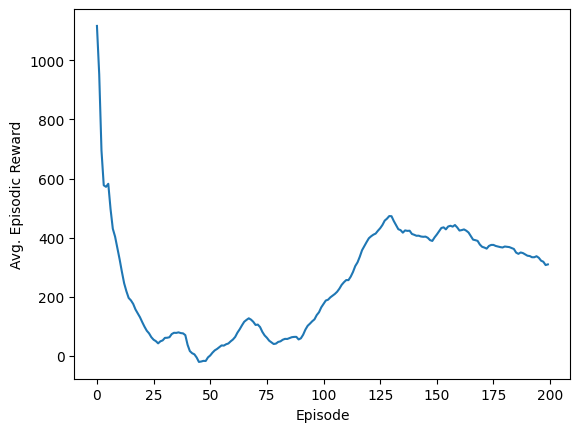

In [10]:
# save params in csv to avoid file name length issue
import csv

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Episodic Reward")

# create UID
import uuid
uid = uuid.uuid4()

# NOTES
note = "2bonus_constnegative_newNN"

# save plot params
dir = "output/"
fname = f"{uid}_E{total_episodes}_"
fname2= "_gamma{gamma}_tau{tau}_nactions{num_actions}_nstates{num_states}_lbound{lower_bound:.2f}_ubound{upper_bound:.2f}_latency{env.latency}_lractor{actor_lr:.4f}_lrcritic{critic_lr:.4f}_stdef{std_dev:.2f}_"+note+".png"

# Create a list of parameter names and values
params = [
    ('uid', str(uid)),
    ('total_episodes', total_episodes),
    ('gamma', gamma),
    ('tau', tau),
    ('num_actions', num_actions),
    ('num_states', num_states),
    ('lower_bound', lower_bound),
    ('upper_bound', upper_bound),
    ('latency', env.latency),
    ('actor_lr', actor_lr),
    ('critic_lr', critic_lr),
    ('std_dev', std_dev),
    ('env.delta_t', env.delta_t),
    ('env.max_t', env.max_t),
    ('env_type', env.__class__.__name__),
    ('note', note)
]

# File name for parameters, using the same uid
params_filename = f"{dir}{uid}_params.csv"

# Write parameters to a CSV file
with open(params_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Parameter', 'Value'])
    writer.writerows(params)

# Save the plot with a simplified name
plot_filename = f"{dir}{uid}_rewards.png"
plt.savefig(plot_filename)

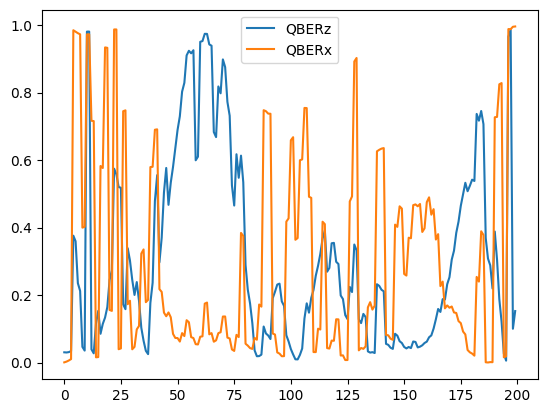

In [11]:
plt.plot(env.qber_history)
plt.legend(["QBERz", "QBERx"])

# Save the plot with a simplified name
plot_filename = f"{dir}{uid}_QBER.png"
plt.savefig(plot_filename)